In [1]:
#!pip install plotnine

In [2]:
import pandas as pd
from plotnine import  * 
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Rotten Tomatoes Movies

The dataset "movieratings.csv" contains critic ratings (Tomato Meter) and audience ratings (Audience) for 200 random movies found in the Rotten Tomato movie database. 

Our goals are to:

1. understand the relationship between critic and audience scores, 
2. fit a (linear) model to summarize this relationship, and
3. use it to predict audience ratings for movies which have evaluated by critics. 

Let's look at the first couple of movies: 

In [3]:
# Read CSV file
ratings = pd.read_csv("/Users/lokeshmuvva/Documents/regression_f25/data/movieratings.csv")

# Display the first few rows
print(ratings.head())

   movie_id    movie_title  tomatometer_rating  audience_rating
0     17401   Willow Creek                81.0             34.0
1      4775        Colonia                26.0             61.0
2     13218  She's the Man                43.0             79.0
3     10539         Mongol                86.0             76.0
4      8462           I.Q.                44.0             47.0


In [4]:
# Summary statistics for critic ratings
print(ratings['tomatometer_rating'].describe())

count    198.000000
mean      60.742424
std       27.065990
min        0.000000
25%       39.250000
50%       64.500000
75%       86.000000
max      100.000000
Name: tomatometer_rating, dtype: float64


In [5]:
# Summary statistics for audience ratings
print(ratings['audience_rating'].describe())

count    199.000000
mean      61.608040
std       19.118639
min       13.000000
25%       47.000000
50%       64.000000
75%       77.500000
max       94.000000
Name: audience_rating, dtype: float64


Let's try to plot critic rating (predictor, on the x-axis) vs. audience rating (response, on the y-axis) for each of our movies. 

In this course, we'll use ggplot for visualization. We'll learn ggplot syntax as we go on an as-needed basis.

/Users/lokeshmuvva/Documents/Temp/ENV/linreg/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


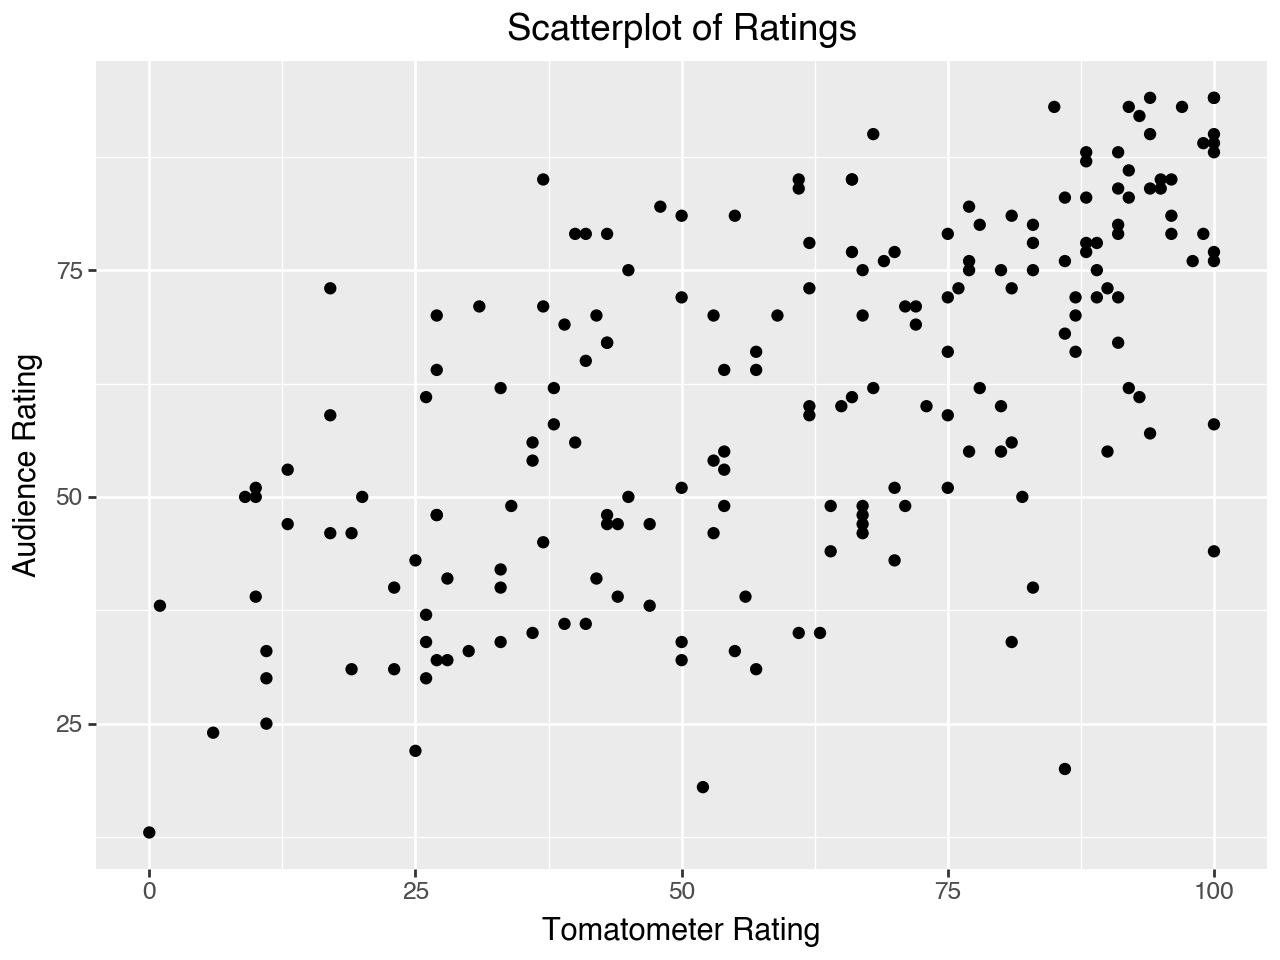

In [6]:
ggplot(ratings, aes(x='tomatometer_rating', y='audience_rating')) + \
    geom_point() + \
    labs(title='Scatterplot of Ratings', x='Tomatometer Rating', y='Audience Rating') #label x and y axes in words


/Users/lokeshmuvva/Documents/Temp/ENV/linreg/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


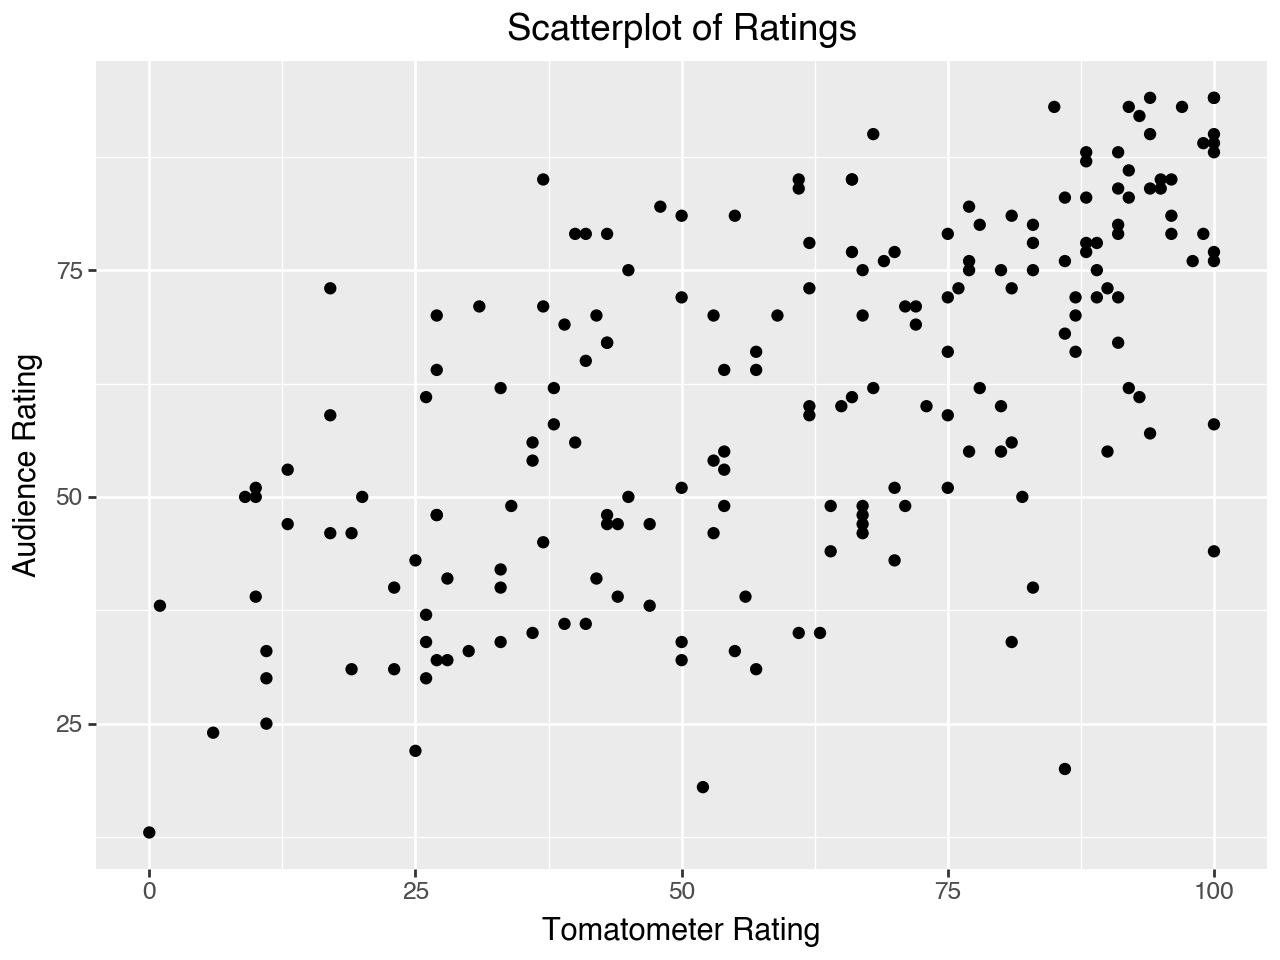

In [7]:
# Scatter plot
plot1 = (
    ggplot(ratings, aes(x='tomatometer_rating', y='audience_rating')) + #define dataframe, x var & y var
    geom_point() + #type of plot: scatterplot
    labs(title='Scatterplot of Ratings', x='Tomatometer Rating', y='Audience Rating') #label x and y axes in words
)
plot1

In [8]:
# Identifying complete cases
complete_index = ratings.notnull().all(axis=1) #not null entries in all columns (cols <-> axis = 1)

In [9]:
complete_index

0      True
1      True
2      True
3      True
4      True
       ... 
195    True
196    True
197    True
198    True
199    True
Length: 200, dtype: bool

In [10]:
print(complete_index.describe()) #summary

count      200
unique       2
top       True
freq       197
dtype: object


In [11]:
# Movies with missing data
ratings[~complete_index]#~ is a negation operator  – switches True to False and vice versa

,movie_id,movie_title,tomatometer_rating,audience_rating
45,9326,Le Deuxième souffle (Second Breath),NaN,67.0
52,15191,The Hunt,83.0,NaN
103,17532,"The World, the Flesh and the Devil",NaN,67.0


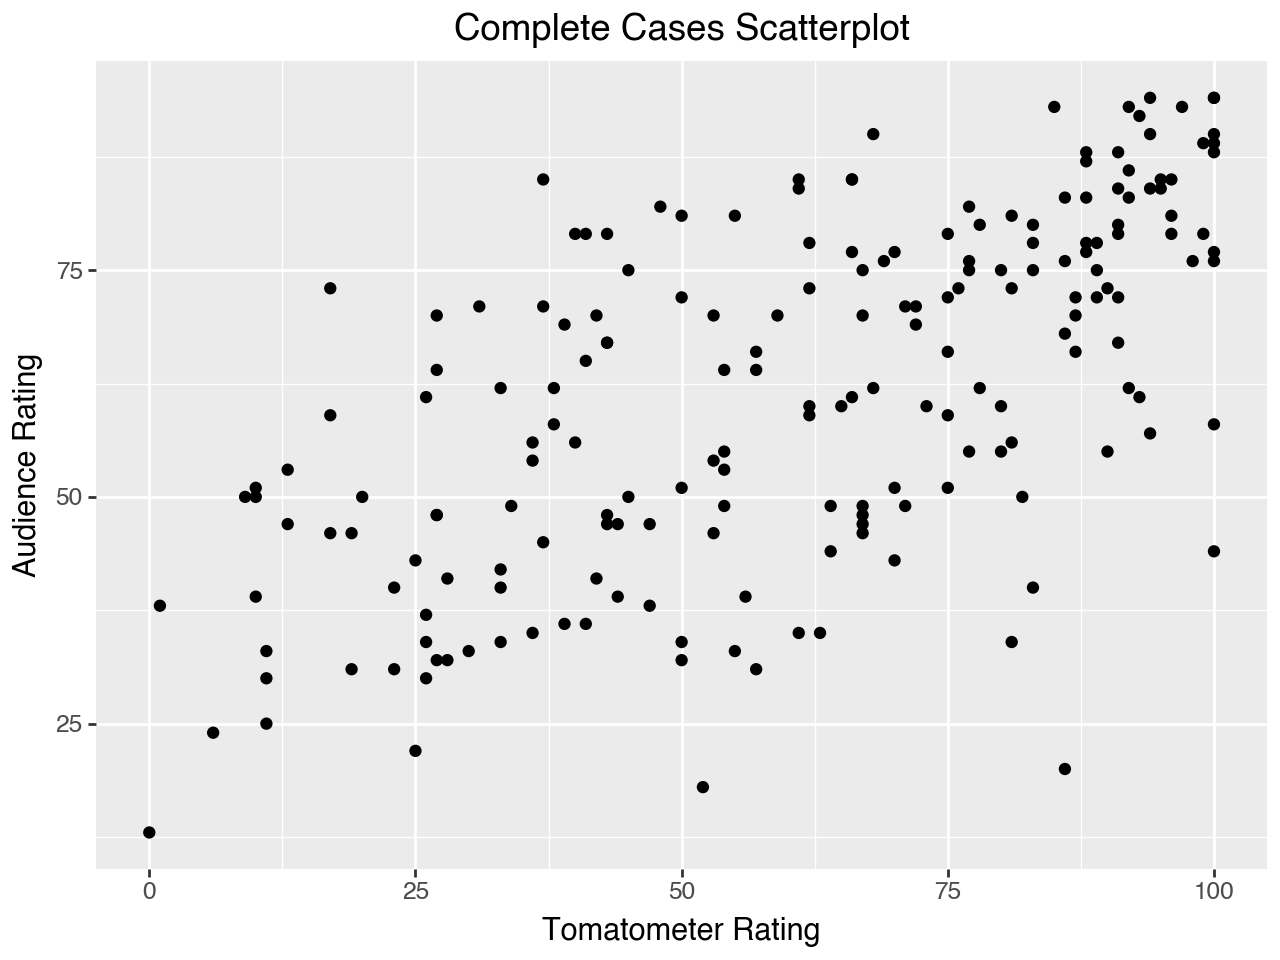

In [12]:
# Complete cases
ratings_complete = ratings[complete_index].copy() #use copy to allow changes to the DataFrame later on without modifying the original df

# Scatter plot for complete cases
plot2 = (
    ggplot(ratings_complete, aes(x='tomatometer_rating', y='audience_rating')) +
    geom_point() +
    labs(title='Complete Cases Scatterplot', x='Tomatometer Rating', y='Audience Rating')
)
plot2

In [13]:
# Correlation
correlation = ratings_complete['tomatometer_rating'].corr(ratings_complete['audience_rating'])
print("Correlation:", correlation)

Correlation: 0.6290515914605515


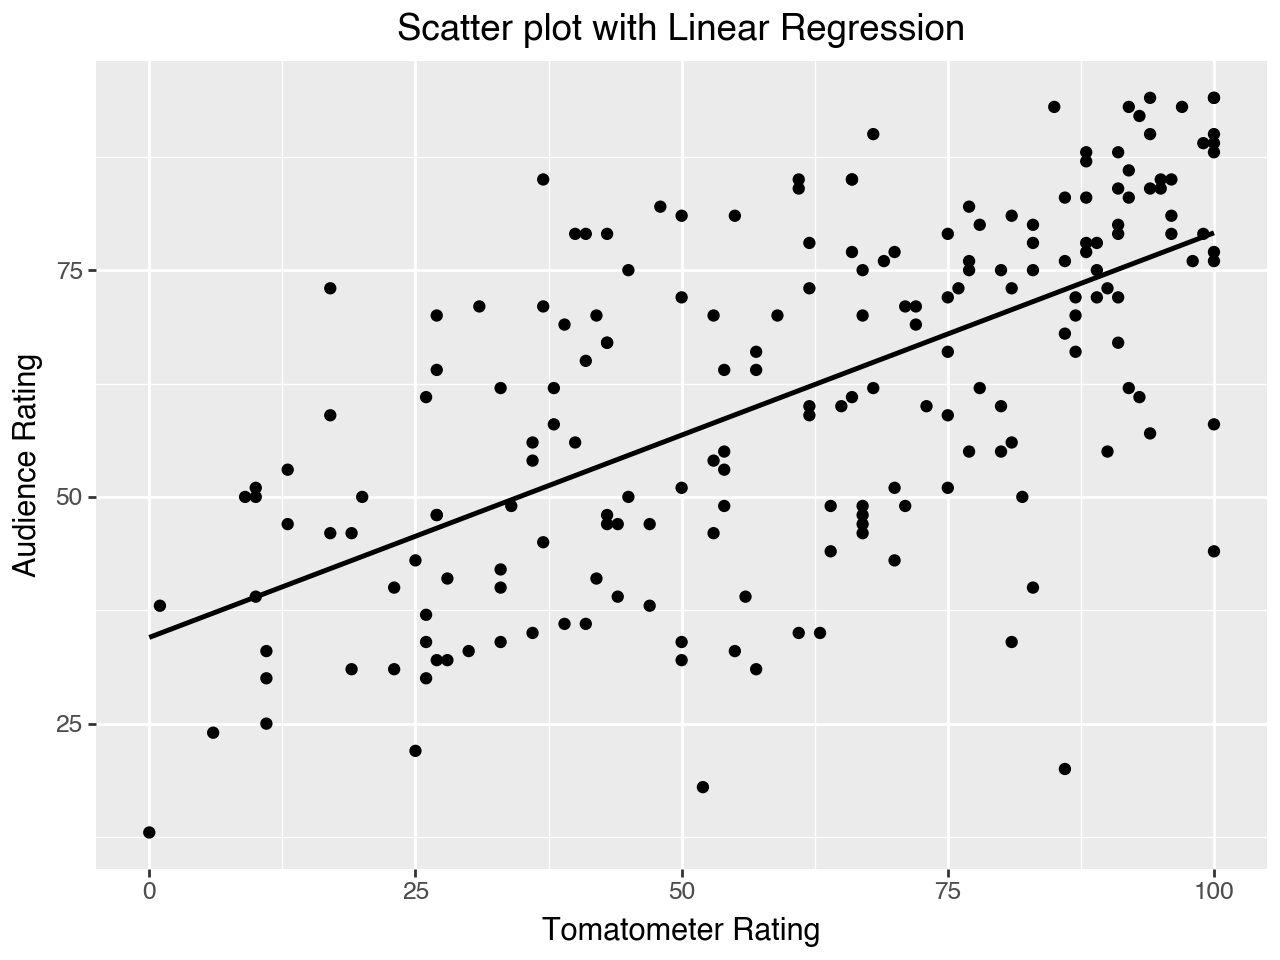

In [14]:
# Scatter plot with linear regression line
plot3 = (
    ggplot(ratings_complete, aes(x='tomatometer_rating', y='audience_rating')) +
    geom_point() +
    geom_smooth(method='lm', formula='y ~ x', se=False) +
    labs(title='Scatter plot with Linear Regression', x='Tomatometer Rating', y='Audience Rating')
)
plot3

The black line represents the fitted regression line:

$\hat{y}_i = 34.5089 + 0.4461 x_i$

or

$\widehat{audience\_rating}_i = 34.5089 + 0.4461 * tomatometer\_rating_i$ 

**Interpretations:**

Slope: For every unit increase in [x-variable], we expect [y-variable] to increase by $\hat{\beta}_1$ [y-units] on average.

Ex: For every additional increase in the Tomatometer rating, we expect the audience rating to increase by 0.4461 points on average. 


Intercept: For an observation where [x-variable] is zero, we expect its [y-variable] to be $\hat{\beta}_0$ on average.

(Example: https://www.forbes.com/sites/paultassi/2024/08/10/the-borderlands-movie-debuts-with-a-0-on-rotten-tomatoes/ ) 





Y-hat: For an observation where [x-variable] is x_i, we predict its [y-variable] to be $\hat{\beta}_0 + \hat{\beta}_1 x_i$.




(Watch out for nonsense interpretations.) 


## How do I get that line???

### Linear regression in Python 

You can use `Scikit-learn` or `statsmodels` to do linear regression
- `Scikit-learn` focus more on predictions, not much on inference
- `statsmodels` is closer to the functions defined in R, has more inference
- We are going to introduce `sklearn.linear_model`, `statsmodels.api.OLS` and `statsmodels.formula.api.ols` (most common). You are not limited to what I have introduced in class.  


#### 1. Scikit-learn

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
# Fit linear model
X = ratings_complete[['tomatometer_rating']]
y = ratings_complete[['audience_rating']]
model = LinearRegression().fit(X, y)

In [17]:
model.intercept_, model.coef_

(array([34.50894913]), array([[0.4460597]]))

In [18]:
# Linear model summary
slope = model.coef_[0]
intercept = model.intercept_
print(f"Slope: {slope}, Intercept: {intercept}")

Slope: [0.4460597], Intercept: [34.50894913]


This corresponds to the fitted regression line:

$\hat{y}_i = 34.5089 + 0.4461 x_i$

or

$\widehat{audience\_rating}_i = 34.5089 + 0.4461 * tomatometer\_rating_i$ 


In [19]:
ratings_complete.head()

,movie_id,movie_title,tomatometer_rating,audience_rating
0,17401,Willow Creek,81.0,34.0
1,4775,Colonia,26.0,61.0
2,13218,She's the Man,43.0,79.0
3,10539,Mongol,86.0,76.0
4,8462,I.Q.,44.0,47.0


In [20]:
# Predicted values and residuals -- add to DataFrame
ratings_complete.loc[:, 'predicted'] = model.predict(X)
ratings_complete.loc[:, 'residuals'] = ratings_complete['audience_rating'] - ratings_complete['predicted']

In [21]:
ratings_complete.head()

,movie_id,movie_title,tomatometer_rating,audience_rating,predicted,residuals
0,17401,Willow Creek,81.0,34.0,70.639785,-36.639785
1,4775,Colonia,26.0,61.0,46.106501,14.893499
2,13218,She's the Man,43.0,79.0,53.689516,25.310484
3,10539,Mongol,86.0,76.0,72.870083,3.129917
4,8462,I.Q.,44.0,47.0,54.135576,-7.135576


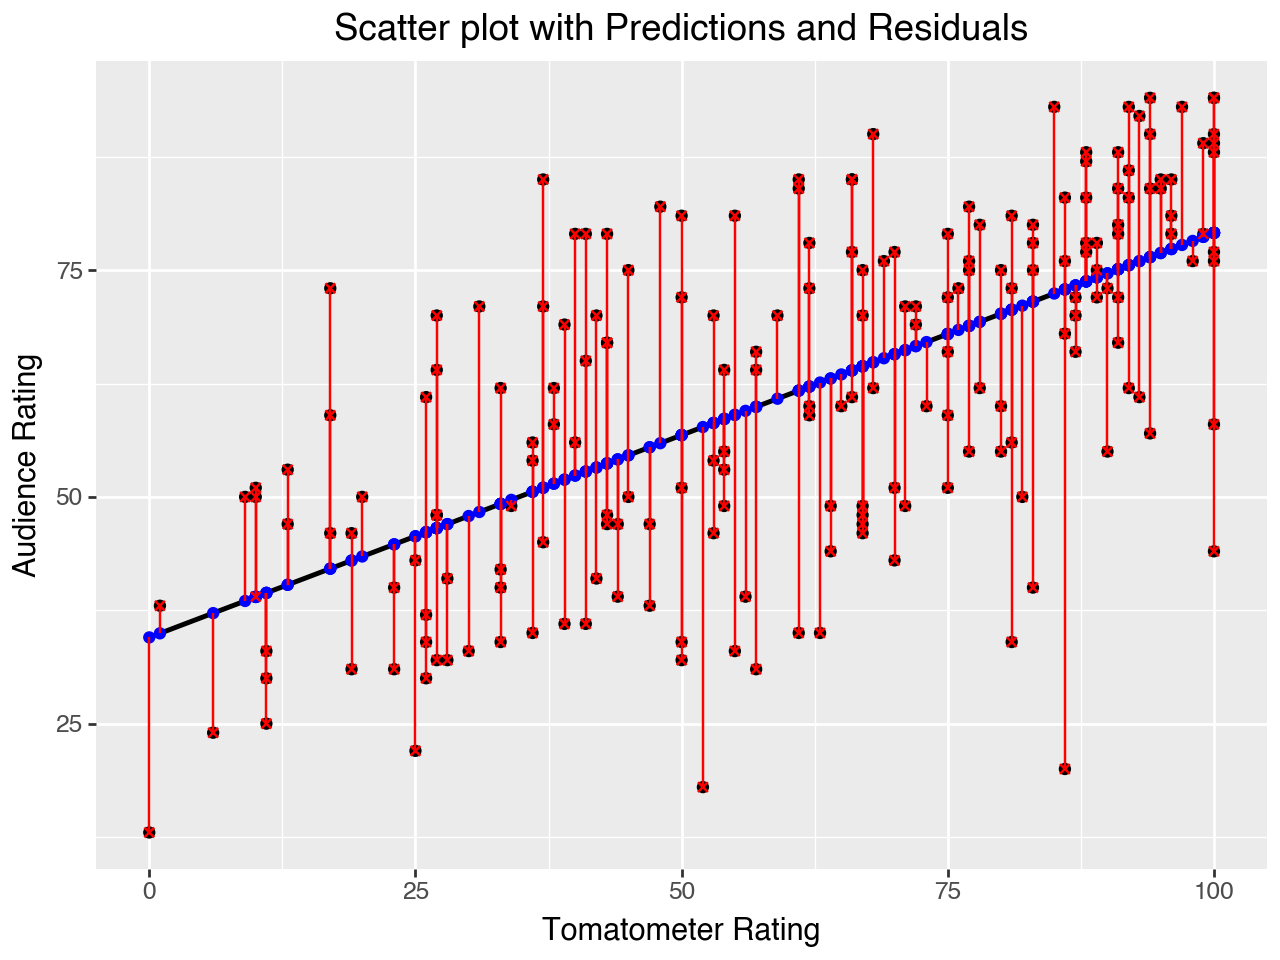

In [22]:
# Scatter plot with predicted values and residuals
plot4 = (
    ggplot(ratings_complete, aes(x='tomatometer_rating', y='audience_rating')) +
    geom_point() +
    geom_smooth(method='lm', formula='y ~ x', se=False) +
    geom_point(aes(y='predicted'), shape='o', color='blue') +
    labs(title='Scatter plot with Predictions and Residuals', x='Tomatometer Rating', y='Audience Rating') +
    geom_point(aes(y='audience_rating'), shape='x', color='red') + 
    geom_segment(aes(xend = 'tomatometer_rating', yend = 'predicted'), color = "red")
)
plot4

### Prediction for a new data point


In [23]:
tomatometer_rating = 88
predicted_audience_rating = intercept + slope * tomatometer_rating
print(f"Predicted audience rating for tomatometer rating of {tomatometer_rating}: {predicted_audience_rating}")

Predicted audience rating for tomatometer rating of 88: [73.76220247]


In [24]:
# Alternative prediction using the model
barbie = pd.DataFrame({'tomatometer_rating': [88]})
pred = model.predict(barbie)
print("Predicted audience rating for 'Barbie':", pred)

Predicted audience rating for 'Barbie': [[73.76220247]]


Compare our prediction to: https://www.rottentomatoes.com/m/barbie

In [25]:
type(pred), type(pred[0]), type(pred[0][0])

(numpy.ndarray, numpy.ndarray, numpy.float64)

#### 2. Use `statsmodels.api.OLS` to fit the data and check inference results

In [26]:
import statsmodels.api as sm

model_noint = sm.OLS(ratings_complete.audience_rating, ratings_complete.tomatometer_rating).fit() #order is y, x
model_noint.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        audience_rating   R-squared (uncentered):                   0.899
Model:                            OLS   Adj. R-squared (uncentered):              0.899
Method:                 Least Squares   F-statistic:                              1747.
Date:                Mon, 25 Aug 2025   Prob (F-statistic):                    1.38e-99
Time:                        10:41:57   Log-Likelihood:                         -874.29
No. Observations:                 197   AIC:                                      1751.
Df Residuals:                     196   BIC:                                      1754.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
tomatometer_rating     0.9209      0.022     41.802      0.000       0.877       0.964
==============================================================================
Omnibus:                        0.452   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.798   Jarque-Bera (JB):                0.193
Skew:                          -0.001   Prob(JB):                        0.908
Kurtosis:                       3.153   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Hmm... 
But wait... there's only a slope, no intercept. This is a problem. 


To fix this in statsmodels, add an intercept to the predictor matrix:

In [27]:
predictor = ratings_complete[['tomatometer_rating']]
X = sm.add_constant(predictor)

In [28]:
X

,const,tomatometer_rating
0,1.0,81.0
1,1.0,26.0
2,1.0,43.0
3,1.0,86.0
4,1.0,44.0
...,...,...
195,1.0,95.0
196,1.0,81.0
197,1.0,91.0
198,1.0,28.0


In [29]:
model_int = sm.OLS(ratings_complete.audience_rating, X).fit() 
model_int.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        audience_rating   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     127.7
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           4.23e-23
Time:                        10:41:57   Log-Likelihood:                -811.62
No. Observations:                 197   AIC:                             1627.
Df Residuals:                     195   BIC:                             1634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 34.5089      2.620     13.170      0.000      29.341      39.677
tomatometer_rating     0.4461      0.039     11.300      0.000       0.368       0.524
==============================================================================
Omnibus:                        5.349   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                5.192
Skew:                          -0.397   Prob(JB):                       0.0746
Kurtosis:                       3.057   Cond. No.                         163.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now the fitted model is the same:

$\hat{y}_i = 35.5089 + 0.4461 x_i$

or

$\widehat{audience\_rating}_i = 35.5089 + 0.4461 * tomatometer\_rating_i$ 


#### 3. R style: `statsmodels.formula.api.ols`

In [30]:
import statsmodels.formula.api as smf

model = smf.ols('audience_rating ~ tomatometer_rating',ratings_complete).fit() #formula: 'y~x' or 'y~x1+x2+x3..'
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        audience_rating   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     127.7
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           4.23e-23
Time:                        10:41:57   Log-Likelihood:                -811.62
No. Observations:                 197   AIC:                             1627.
Df Residuals:                     195   BIC:                             1634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             34.5089      2.620     13.170      0.000      29.341      39.677
tomatometer_rating     0.4461      0.039     11.300      0.000       0.368       0.524
==============================================================================
Omnibus:                        5.349   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                5.192
Skew:                          -0.397   Prob(JB):                       0.0746
Kurtosis:                       3.057   Cond. No.                         163.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Output

- Covariance type is typically nonrobust which means there is no elimination of data to calculate the covariance between features.
- std err of tomatometer_rating: the estimated standard error of $\hat{\beta}_1$:

$Var(\hat{\beta}_1) = \frac{\sigma^2}{SSX}$

estimate $\sigma^2$ with $\hat{\sigma}^2 = MSE=\frac{\sum_i(y_i-\hat{y}_i)^2}{n-2}$

estimate the standard deviation of $\hat{\beta}_1$ with $\frac{\hat{\sigma}}{\sqrt{SSX}}$

$\widehat{SE}(\hat{\beta}_1) =\frac{\hat{\sigma}}{\sqrt{SSX}}$

In [31]:
#extract MSE

model.mse_resid

np.float64(224.09918145536398)

In [32]:
#Find SSX = sum(Xi-X_bar)^2

SSX=np.sum((ratings_complete.tomatometer_rating-np.mean(ratings_complete.tomatometer_rating))**2) #sum(Xi-X_bar)^2
SSX

np.float64(143817.9492385787)

In [33]:
#calculate se

se_beta_1 = np.sqrt(model.mse_resid/SSX)
se_beta_1

np.float64(0.03947422291390177)

In [34]:
print(model.params)

Intercept             34.508949
tomatometer_rating     0.446060
dtype: float64


In [35]:
t = model.params.iloc[1]/se_beta_1
t

np.float64(11.300024777935613)

<b>Omnibus/Prob(Omnibus)</b> - a test of the skewness and kurtosis of the residual. We hope to see a value close to zero which would indicate normalcy. The Prob (Omnibus) performs a statistical test indicating the probability that the residuals are normally distributed. We hope to see something close to 1 here.

<b>Skew</b> - a measure of data symmetry. We want to see something close to zero, indicating the residual distribution is normal. Note that this value also drives the Omnibus. https://en.wikipedia.org/wiki/Skewness

<b>Kurtosis</b> - a measure of "peakedness", or curvature of the data. Higher peaks lead to greater Kurtosis. A standard normal distribution has kurtosis of 3 and is recognized as mesokurtic. An increased kurtosis (>3) can be visualized as a thin “bell” with a high peak whereas a decreased kurtosis corresponds to a broadening of the peak and “thickening” of the tails. https://en.wikipedia.org/wiki/Kurtosis

<b>Durbin-Watson</b> - tests for homoscedasticity. We hope to have a value between 1 and 2 to indicate uncorrelated residuals.https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic

<b>Jarque-Bera (JB)/Prob(JB)</b> - like the Omnibus test in that it tests both skew and kurtosis for normality. We hope to see in this test a confirmation of the Omnibus test. https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test

<b>Condition Number</b> - This is a somewhat complicated mathematical concept (https://en.wikipedia.org/wiki/Condition_number#:~:text=In%20linear%20regression%20the%20condition,a%20relative%20change%20in%20input.) to test for multicollinearity (later).  This does not apply to SLR. we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30. 


### ANOVA and F-test

In [36]:
aov_table = sm.stats.anova_lm(model, typ=1)
aov_table

# we will explain the 'typ' argument later in MLR. It doesn't matter in SLR.

,df,sum_sq,mean_sq,F,PR(>F)
tomatometer_rating,1.0,28615.349972,28615.349972,127.69056,4.227557e-23
Residual,195.0,43699.340384,224.099181,NaN,NaN


#### Fitted values, Predictions and Confidence/Prediction Intervals

In [37]:
fitted = model.predict(ratings_complete.tomatometer_rating)
fitted

0      70.639785
1      46.106501
2      53.689516
3      72.870083
4      54.135576
         ...    
195    76.884620
196    70.639785
197    75.100382
198    46.998621
199    75.992501
Length: 197, dtype: float64

#### Confidence/Prediction Intervals... e.g. for Barbie

In [38]:
prediction=model.get_prediction(exog=dict(tomatometer_rating=barbie.tomatometer_rating))
prediction.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,73.762202,1.518187,70.768028,76.756377,44.086981,103.437424


#### Use residual plots to check model assumptions

- The error terms have constant variance: significant change in the bandwidth might suggest violation.
- The error terms are independent： obvious patterns might suggest violation 
- Potential problems: two clusters might suggest the sample came from different populations


Let's use a more complicated dataset for this part:

In [39]:
boston = pd.read_csv("../data/boston_housing.csv")

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/


This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.


In [40]:
boston.shape

(506, 14)

In [41]:
print(list(boston.columns))

['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat', 'medv']


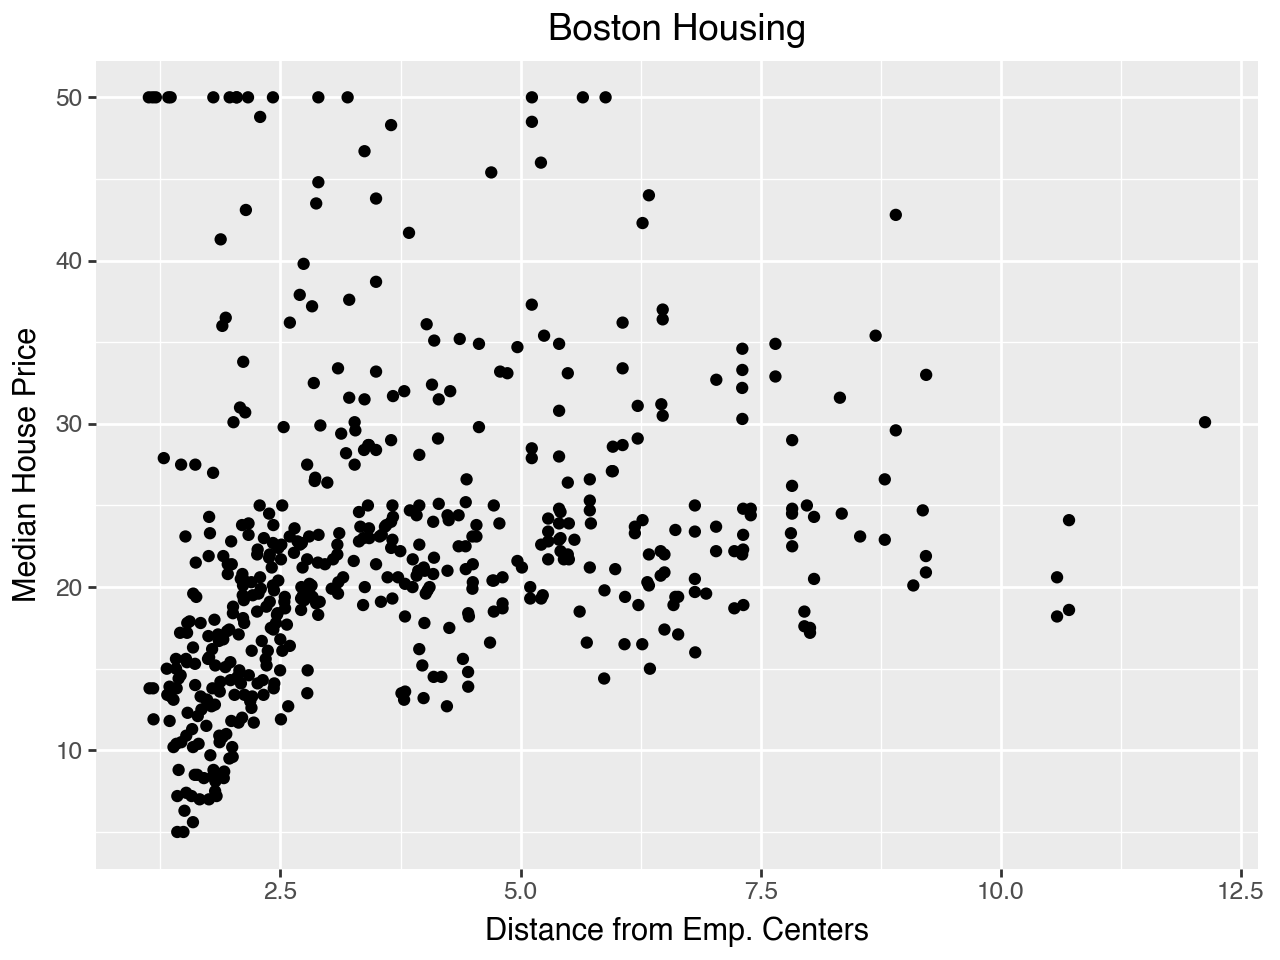

In [42]:
plot_bos = (
    ggplot(boston, aes(x='dis', y='medv')) +
    geom_point() +
    labs(title='Boston Housing', x='Distance from Emp. Centers', y='Median House Price')
)
plot_bos

In [43]:
#fit a model
import statsmodels.formula.api as smf
model = smf.ols('medv ~ dis', boston).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     33.58
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           1.21e-08
Time:                        10:41:57   Log-Likelihood:                -1823.9
No. Observations:                 506   AIC:                             3652.
Df Residuals:                     504   BIC:                             3660.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.3901      0.817     22.499      0.000      16.784      19.996
dis            1.0916      0.188      5.795      0.000       0.722       1.462
==============================================================================
Omnibus:                      139.779   Durbin-Watson:                   0.570
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              305.104
Skew:                           1.466   Prob(JB):                     5.59e-67
Kurtosis:                       5.424   Cond. No.                         9.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

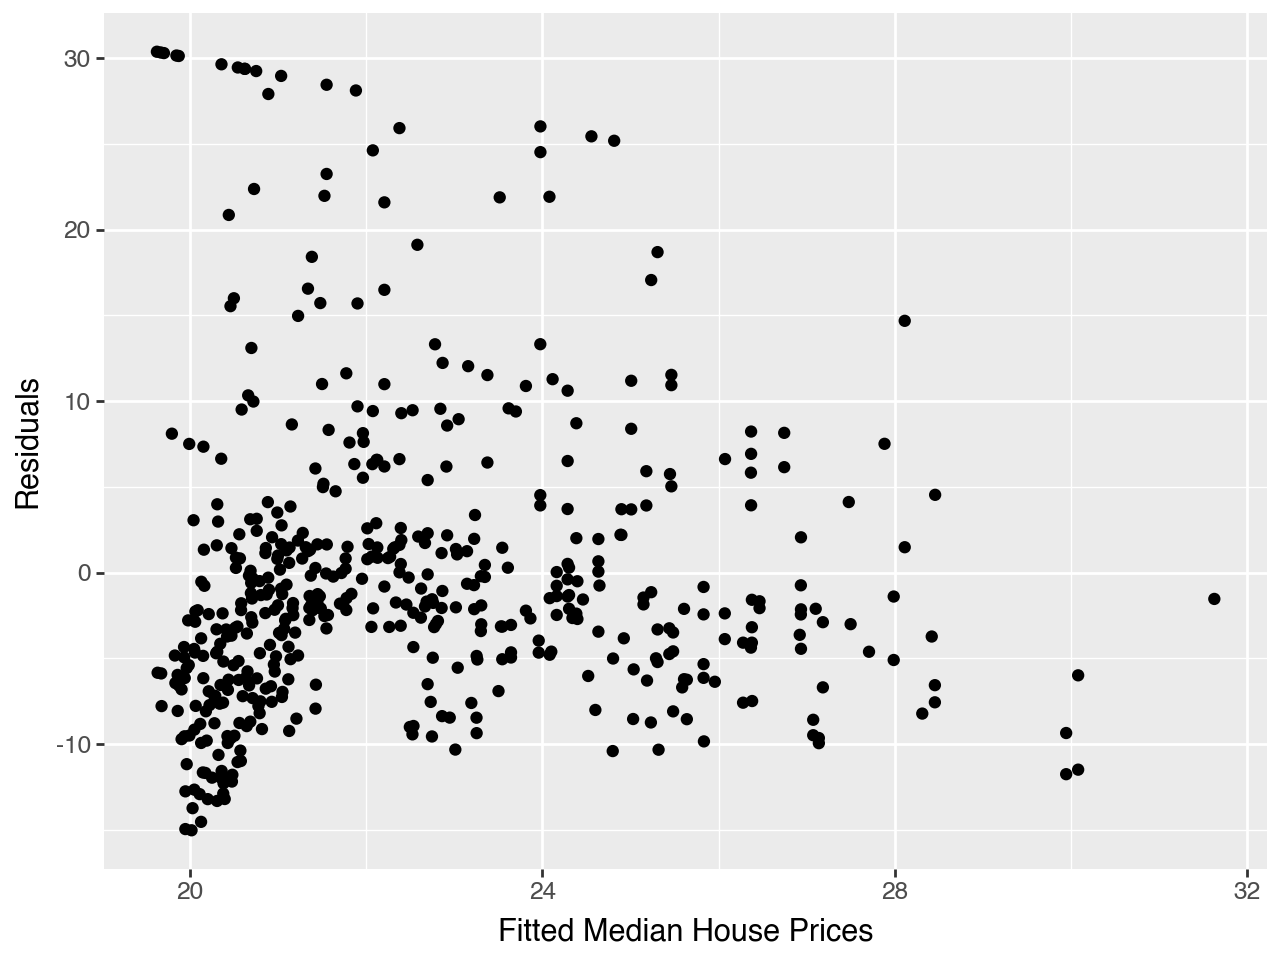

In [44]:
#Fitted Values vs. Residuals
boston.loc[:, 'predicted'] = model.fittedvalues
boston.loc[:, 'residuals'] = model.resid

plot_bos_resid = (
    ggplot(boston, aes(x='predicted', y='residuals')) +
    geom_point() +
    labs( x='Fitted Median House Prices', y='Residuals')
)
plot_bos_resid

Questions:

- What model assumptions might be violated and in which way?

1. Linear relationship between X and Y? Not sure. Might suggest need to transform data for a better fit.

2. Constant variance over X? Doesn't look like it. We will learn how to deal with this in a week or two. 

3. Indepedence of errors? Maybe. Towns may be clustered together geographically or have some other dependence. Checking this assumption normally means looking into the sampling scheme and data acquisition methods.

4. Normally distributed residuals? For this, we can 1. look at a histogram of residuals and 2. examine the QQ plot. 


For this model, our residuals are right-skewed. They don't look very normally distributed.

/Users/lokeshmuvva/Documents/Temp/ENV/linreg/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 24'. Pick better value with 'binwidth'.


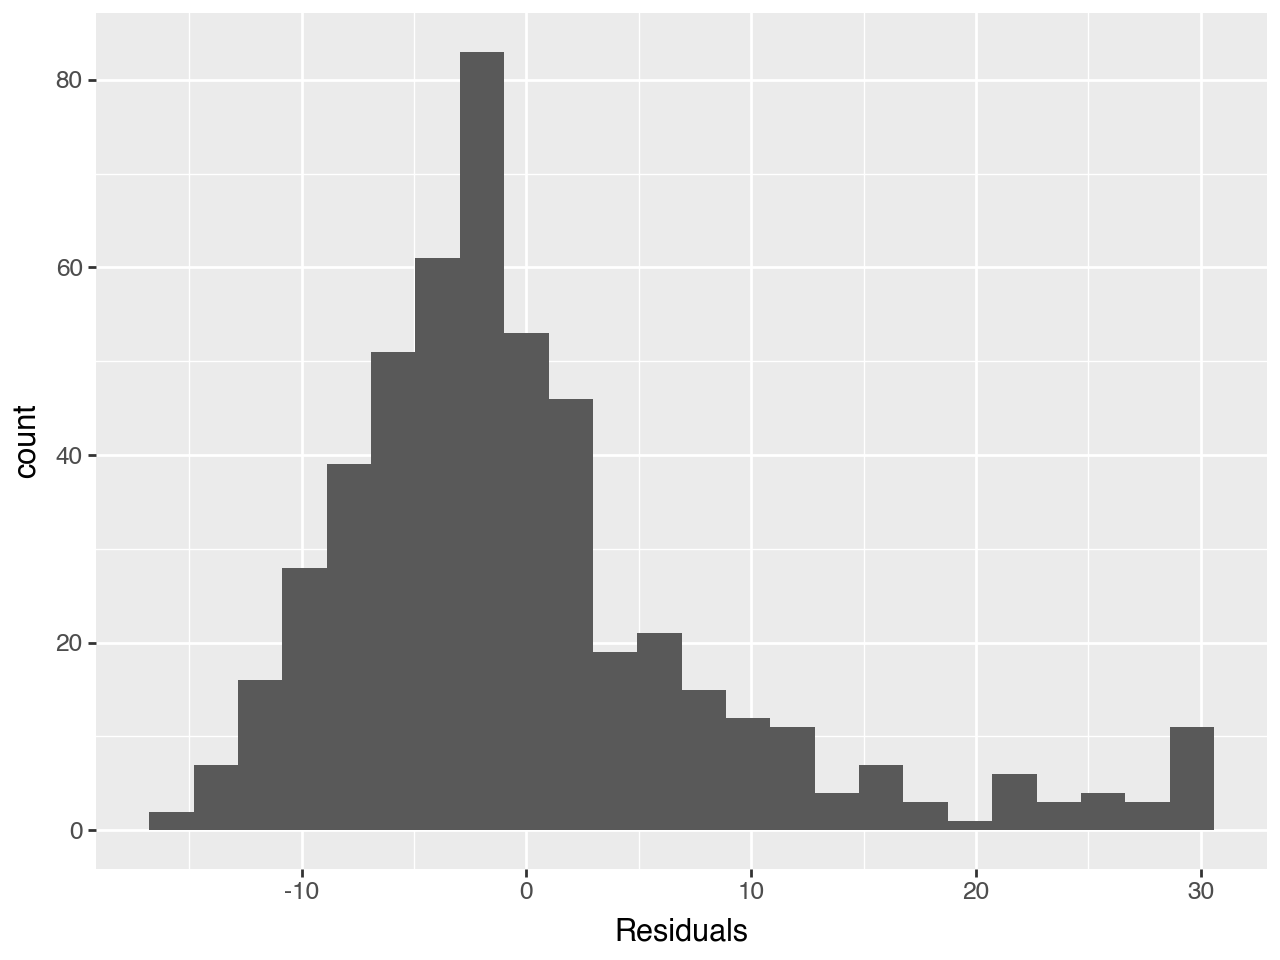

In [45]:
(ggplot(boston, aes(x='residuals')) +
    geom_histogram() +
    labs(x='Residuals'))

Another way to see this is through the QQ plot. 

Roughly here are the basics on how to interpret these:

- If the points fall on the diagonal line, then residuals are approximately Normally distributed.
- If the points create a "J" shape, the residuals are right-skewed (not Normal).
- If the points create an "r" shape, the residuals are left-skewed (not Normal).
- If the points create a symmetric "S" shape, the residuals have a symmetric distribution with lighter tails than a Normal distribution.  (Extreme errors are less likely to occur than in the Normal model.)
- If the points create a reflected symmetric "S" shape, the residuals have a symmetric distribution with heavier tails than a Normal distribution. (Extreme errors are more likely to occur than in the Normal model.)

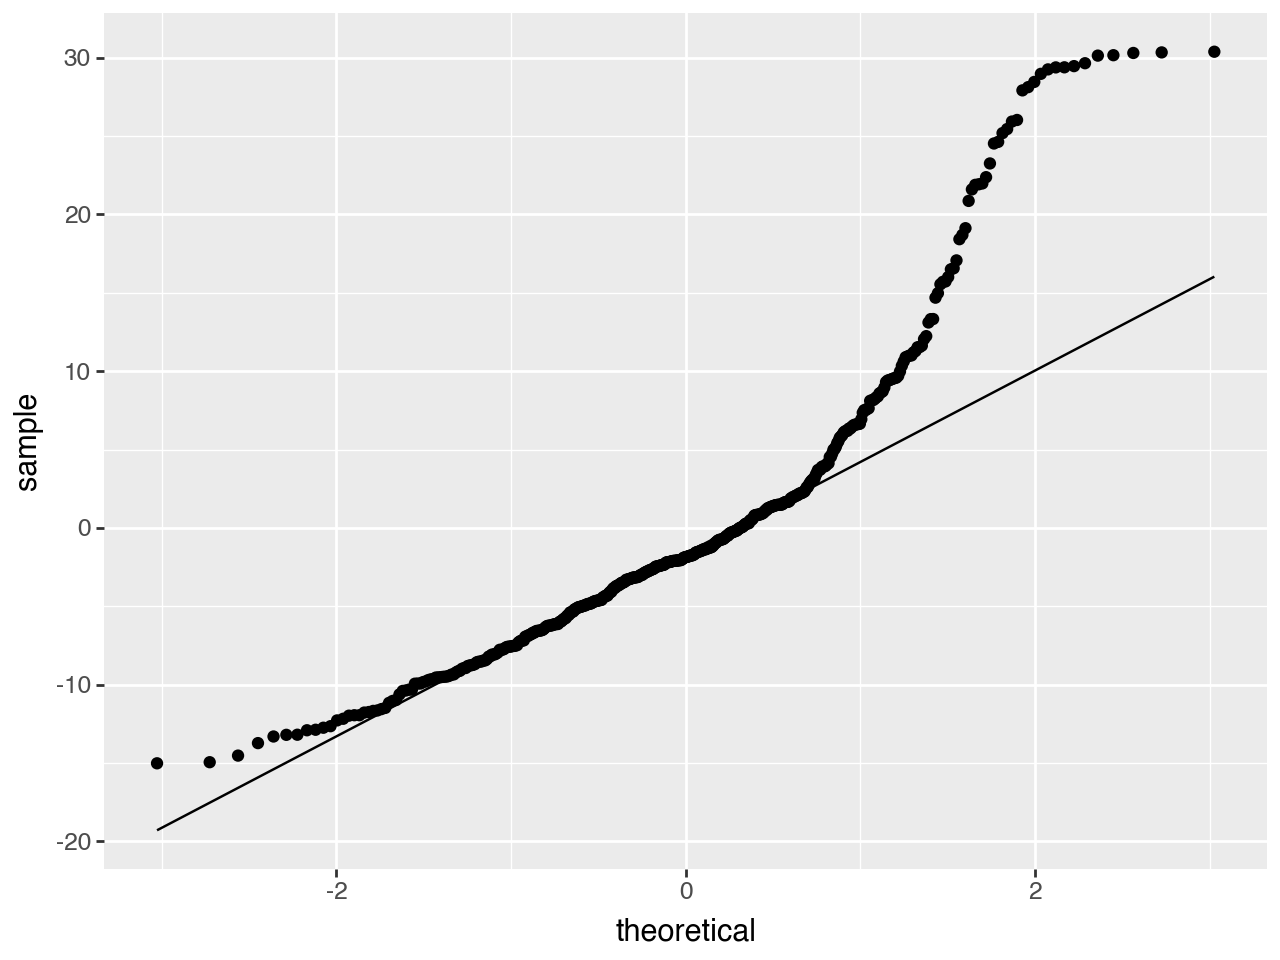

In [46]:
(ggplot(boston, aes(sample='residuals')) +
     stat_qq() + stat_qq_line())

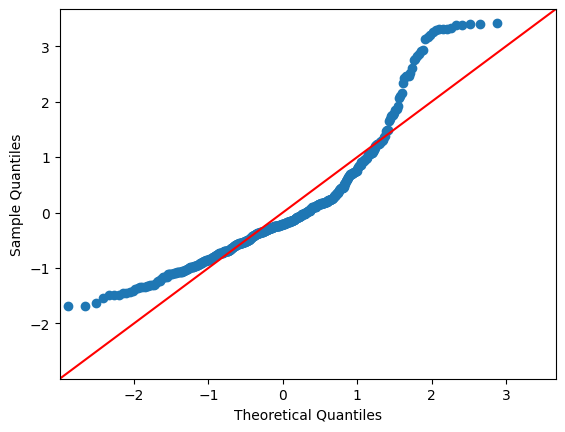

In [47]:
#qq plot
sm.qqplot(model.resid / np.std(model.resid), line = '45')

<b> Question </b>

What model assumptions might be violated and in which way?

- Normal distribution: seems to follow for smaller values of residuals, but have a heavy right tail.
- Suggesting model is not fitting well for some observations. Might consider a different  model(transformation) for a better fit. 

In [48]:
#quick and dirty transformation, details later
modelnew = smf.ols('np.log(medv) ~ np.log(dis)',boston).fit()

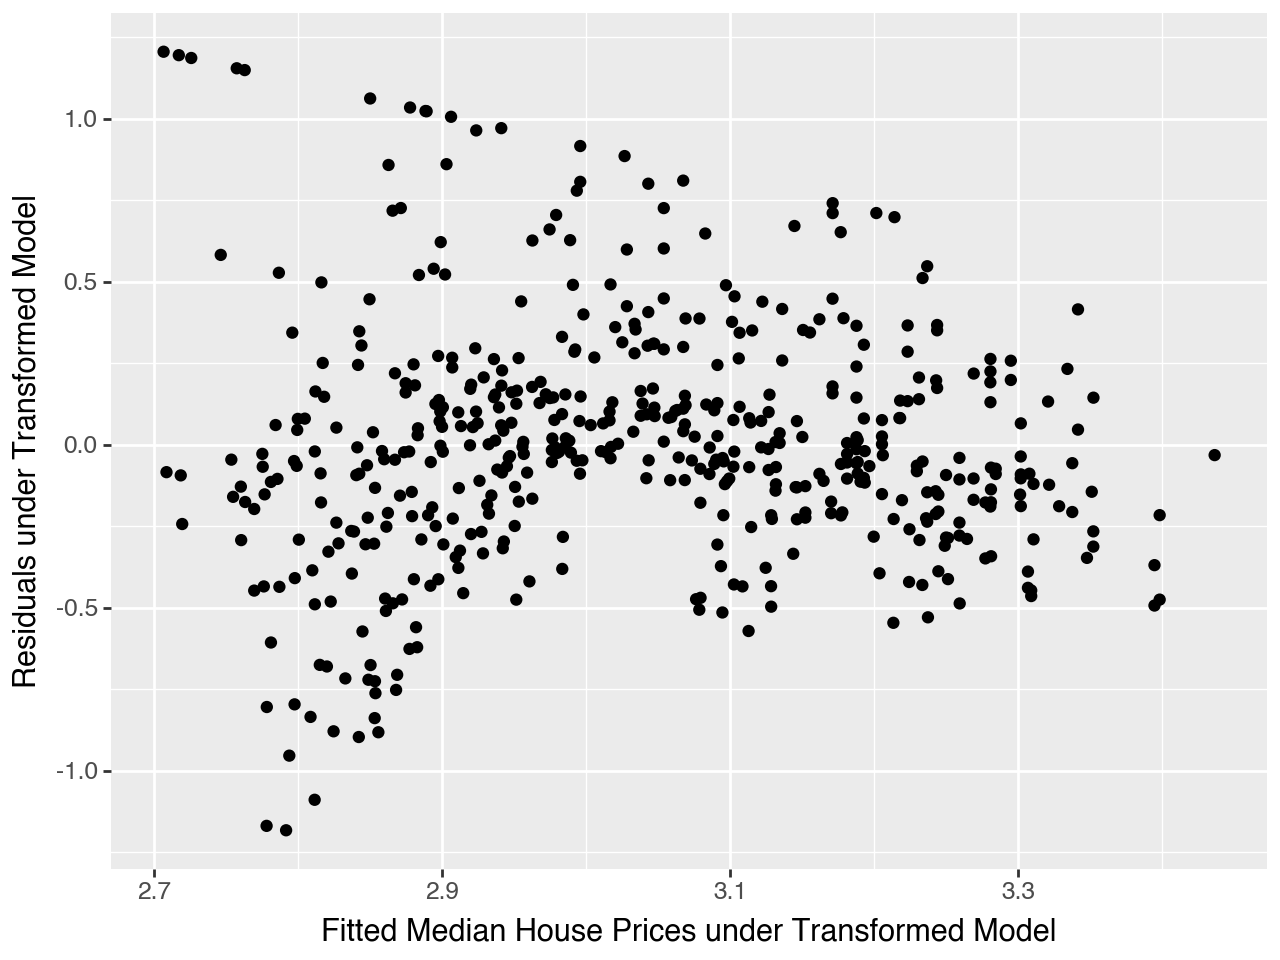

In [49]:
boston.loc[:, 'predicted_trans'] = modelnew.fittedvalues
boston.loc[:, 'residuals_trans'] = modelnew.resid
plot_bos_resid_trans = (
    ggplot(boston, aes(x='predicted_trans', y='residuals_trans')) +
    geom_point() +
    labs( x='Fitted Median House Prices under Transformed Model', y='Residuals under Transformed Model')
)
plot_bos_resid_trans

What is improved?


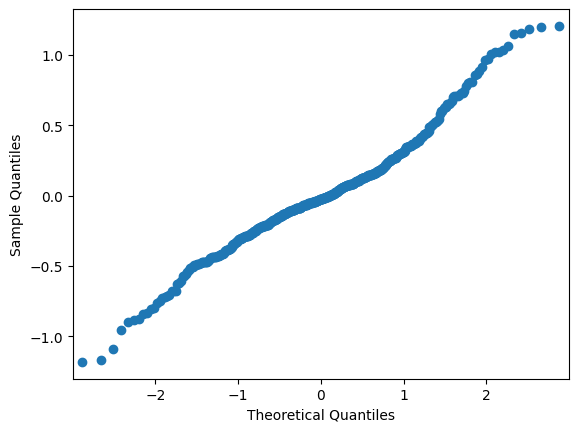

In [50]:
#qq plot
sm.qqplot(modelnew.resid)

## Practice with QQ plots
Simulate a set of data from the simple linear model which results in residuals which are:
 1. Normal
 2. right-skewed ("J")
 3. left-skewed ("r")
 4. light-tailed ("S")
 5. heavy-tailed ("reflected S")

Example: #1 -

Normal QQ Plot:

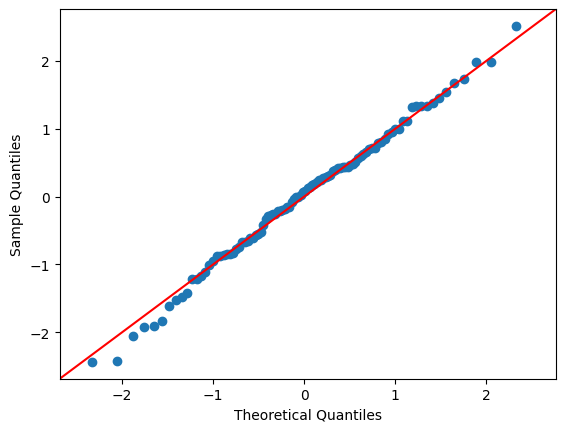

In [51]:
def generate_data_N(sigma):
    X = np.linspace(start=1, stop=10, num=100).reshape(-1, 1) #array w/ 1 column, the -1 means 'infer the # of rows'

    # Define parameters
    beta0 = 4
    beta1 = 3
    
    # Generate epsilon as a 1D array of N(0, sigma^2) RVs
    epsilon = sigma * np.random.randn(100)
    
    # Generate y using SLR model
    y = beta0 + beta1 * X.flatten() + epsilon

    df = pd.DataFrame({
        'x': X.flatten(),
        'y': y
    })

    return df

df = generate_data_N(sigma = 2)
model = smf.ols('y ~ x', df).fit()
sm.qqplot(model.resid / np.std(model.resid), line = '45')

#2. Right skewed QQ:

In [52]:
def generate_data_rightskew():
    X = np.linspace(start=1, stop=10, num=100).reshape(-1, 1) #array w/ 1 column, the -1 means 'infer the # of rows'

    # Define parameters
    beta0 = 4
    beta1 = 3
    
    # Generate epsilon as a 1D array ???? RVs
    epsilon =  stats.chi2.rvs(df = 1, size=100) - 1
    
    # Generate y using SLR model
    y = beta0 + beta1 * X.flatten() + epsilon

    df = pd.DataFrame({
        'x': X.flatten(),
        'y': y
    })

    return df

df = generate_data_rightskew()
model = smf.ols('y ~ x', df).fit()


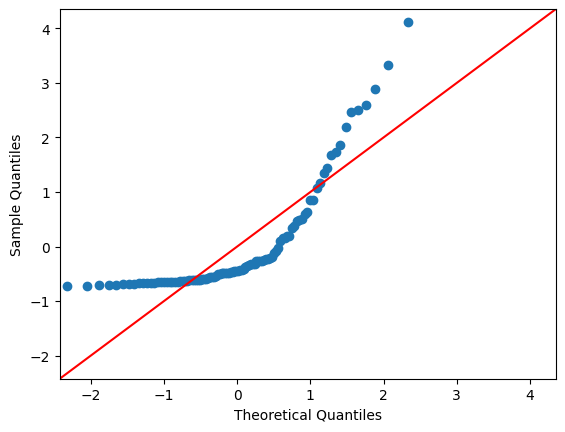

In [53]:
sm.qqplot(model.resid / np.std(model.resid), line = '45')

In [54]:
sm.qqplot(model.resid); #the semicolon here prevents a second duplicate plot from appearing for some reason... lol

In [55]:
def generate_data_leftskew():
    X = np.linspace(start=1, stop=10, num=100).reshape(-1, 1) #array w/ 1 column, the -1 means 'infer the # of rows'

    # Define parameters
    beta0 = 4
    beta1 = 3
    
    # Generate epsilon as a 1D array ???? RVs
    epsilon =  -1 * (stats.chi2.rvs(df = 1, size=100) - 1)
    
    # Generate y using SLR model
    y = beta0 + beta1 * X.flatten() + epsilon

    df = pd.DataFrame({
        'x': X.flatten(),
        'y': y
    })

    return df

df = generate_data_leftskew()
model = smf.ols('y ~ x', df).fit()


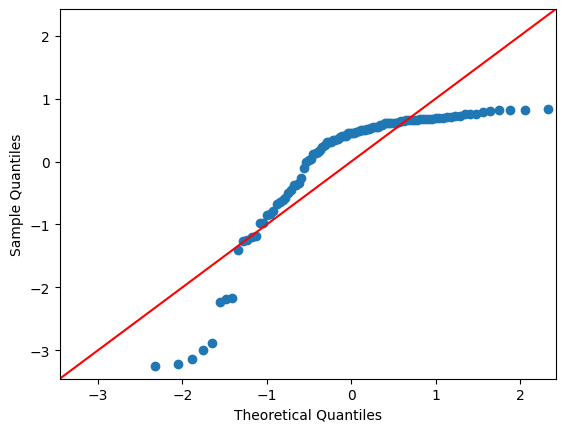

In [56]:
sm.qqplot(model.resid / np.std(model.resid), line = '45')

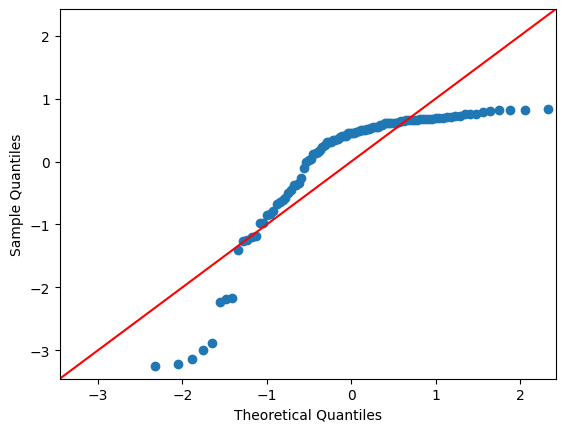

In [57]:
sm.qqplot(model.resid / np.std(model.resid), line = '45')

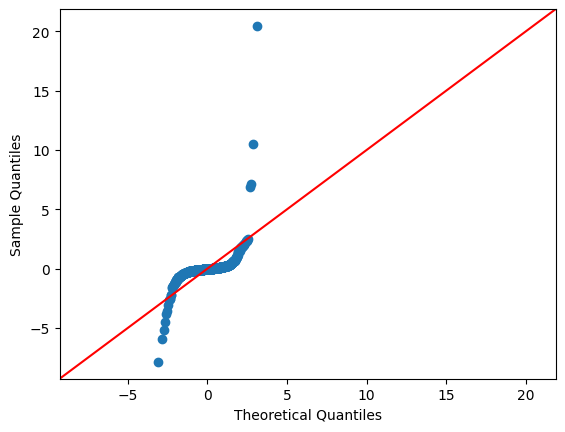

In [58]:
def generate_data_heavy():
    X = np.linspace(start=1, stop=10, num=1000).reshape(-1, 1) #array w/ 1 column, the -1 means 'infer the # of rows'

    # Define parameters
    beta0 = 4
    beta1 = 3
    
    # Generate epsilon as a 1D array ???? RVs
    epsilon =  stats.t.rvs(df = 1, size = 1000)
    
    # Generate y using SLR model
    y = beta0 + beta1 * X.flatten() + epsilon

    df = pd.DataFrame({
        'x': X.flatten(),
        'y': y
    })

    return df

df = generate_data_heavy()
model = smf.ols('y ~ x', df).fit()
sm.qqplot(model.resid / np.std(model.resid), line = '45')

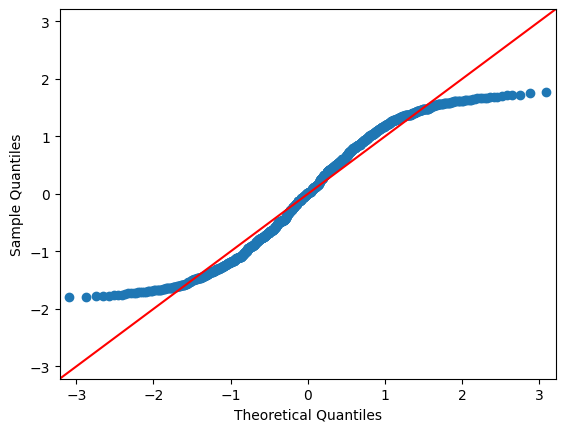

In [59]:
def generate_data_light():
    X = np.linspace(start=1, stop=10, num=1000).reshape(-1, 1) #array w/ 1 column, the -1 means 'infer the # of rows'

    # Define parameters
    beta0 = 4
    beta1 = 3
    
    # Generate epsilon as a 1D array ???? RVs
    epsilon =  stats.uniform.rvs(-1, 2, size = 1000)
    
    # Generate y using SLR model
    y = beta0 + beta1 * X.flatten() + epsilon

    df = pd.DataFrame({
        'x': X.flatten(),
        'y': y
    })

    return df

df = generate_data_light()
model = smf.ols('y ~ x', df).fit()
sm.qqplot(model.resid / np.std(model.resid), line = '45')

And so on for #3, 4, and 5.

#### Practice: credit

The Credit Card Balance Data ("Credit.csv") is a data frame with 400 observations on the following variables:

- ID - Identification
- Income - Income in \$10,000
- Limit - Credit limit
- Rating - Credit rating
- Age - Age in years
- Education - number of years of education
- Gender - Male or Female
- Student - Yes or No
- Married - Yes or No
- Ethnicity - African American, Asian or Caucasian
 Balance - Average credit card balance in \$

Use "Balance" as your reponse variable y, and pick one predictor x
1. Use scatterplot to check the linear relationship between y and x (numeric or categorical). 
2. Fit SLR.
3. Based on the summary table, comment on the significance of your x, the model fit, and the model assumptions.
4. Once you've checked all assumptions, trade with your partner and see if they interpret the diagnostic plots in the same way. (Hint: the 4 diagnostic plots are: the scatterplot of Y vs. X, the residual plot, the histogram of residuals, and the QQ plot.) 